<a href="https://colab.research.google.com/github/kogby/DA_KKTV/blob/neo_branch/0528model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 套件安裝

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab/資料分析期末') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['data',
 'models',
 'preprocessed_output',
 'large0520.ipynb',
 '過往東東',
 '0521KKTV (light).ipynb',
 'submit.csv',
 '嘗試不同duration_conversion.ipynb',
 '0528model.ipynb']

In [2]:
# always needed
import math, os, random, csv
import pandas as pd
import numpy as np

# log and save
import json, logging, pickle, sys, shutil, copy
# torch
import torch
import torch.nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU
import torchvision
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import seaborn as sns

# others
import matplotlib.pyplot as plt
from PIL import Image

# sklearn
from sklearn import preprocessing

# statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statistics

# seeds
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
def show_loss(train_loss, valid_loss):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(train_loss, color='blue', linewidth=2)
    axes[0].set_title('Training Loss', fontsize=16)
    axes[0].set_xlabel('iteration', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].grid(True)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Plot validation loss
    axes[1].plot(valid_loss, color='red', linewidth=2)
    axes[1].set_title('Validation Loss', fontsize=16)
    axes[1].set_xlabel('iteration', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].grid(True)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    plt.show()

## 資料長相（train有source, target / test只有source

In [6]:
#('./preprocessed_output/train_duration_target.npy')
#('./preprocessed_output/duration_data_scaled.npy')
#('./preprocessed_output/test_duration_data_scaled.npy')

In [7]:
duration_mtx = np.load('./preprocessed_output/train_duration_target.npy')
duration_mtx[3]

array([1.        , 1.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 0.70826554, 1.        , 0.        ,
       0.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        ])

## 加載資料

In [8]:
class TrainDataset(Dataset):
    # data loading
    def __init__(self, file_name_X, file_name_Y):
        #X = pd.read_csv(file_name_X).drop(columns=['user_id']).to_numpy()
        #X = X.reshape(X.shape[0], -1, 28) #變成每七天一個vector feature input_size=28, seq_len=37
        X = np.load(file_name_X)
        X = X.reshape(X.shape[0], -1, 4) #變成每七天一個vector feature input_size=28, seq_len=37
        Y = np.load(file_name_Y)
        self.x = torch.from_numpy(X).to(torch.float32)
        self.y = torch.from_numpy(Y).to(torch.float32)
        self.n_samples = self.x.shape[0]
        self.input_size = 4

    # working for indexing
    def __getitem__(self, index):
        return self.x[index], self.y[index] #符合lstm的輸入 (batch_first)
    def __len__(self):
        return self.n_samples

class TestDataset(Dataset):
    # data loading
    def __init__(self, file_name_X):
        X = np.load(file_name_X)
        X = X.reshape(X.shape[0], -1, 4) 
        self.x = torch.from_numpy(X).to(torch.float32)
        self.n_samples = self.x.shape[0]
        self.input_size = 4

    # working for indexing
    def __getitem__(self, index):
        return self.x[index] #符合lstm的輸入 seqlen再改
    def __len__(self):
        return self.n_samples

In [9]:
dataset_train = TrainDataset('./preprocessed_output/duration_data_scaled.npy', './preprocessed_output/train_duration_target.npy')
dataset_test = TestDataset('./preprocessed_output/test_duration_data_scaled.npy')

batch_size = 32 #符合test loader的因數
valid_ratio = 0.2
valid_set_size = int(valid_ratio * len(dataset_train)) #驗證集大小
train_set_size = len(dataset_train) - valid_set_size #訓練集大小
dataset_train, dataset_valid = torch.utils.data.random_split(dataset_train, [train_set_size, valid_set_size])

train_loader = DataLoader(dataset_train ,batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, drop_last=False)

In [10]:
for _, (data, labels) in enumerate(train_loader):
  print(data.shape, labels.shape) #train:1036 columns, test:28 columns 
  break; ## seqlen根据数据特征数量调整，1036/28 = 37

torch.Size([32, 259, 4]) torch.Size([32, 28])


## 模型
https://blog.csdn.net/qq_40728805/article/details/103959254?spm=1001.2101.3001.6650.3&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-103959254-blog-112799785.235%5Ev36%5Epc_relevant_default_base3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-3-103959254-blog-112799785.235%5Ev36%5Epc_relevant_default_base3&utm_relevant_index=4
对于单层单向的LSTM， 其h_n最后一层输出h_n[-1,:,:]，和output最后一个时步的输出output[-1,:,:]相等。如果是分类任务的话，就可以把output[-1, :, :]或者output送到一个分类器分类。

比如：在做文字识别中，先对文本行图片提取feature，如shape为(B, 512, 1, 16)其中512是channel 维度，1是height，16是width，tensor处理为(B, 16, 512)或(16, B, 512)因为lstm要求输入是3D的，CNN的feature是4D的。

那这样，512就是input_size, 16就是seq_len
<br>
輸入LSTM:(batchsize,seqlen,inputsize) when batch_first=True 


https://discuss.pytorch.org/t/understanding-lstm-input/31110/5 LSTM input

In [11]:
class SimpleLSTM(nn.Module):

    def __init__(self):
        super(SimpleLSTM, self).__init__()

        self.input_size = 4 #一週七天*4 slot
        self.seq_len = int(1036/self.input_size)

        self.n_layers = 2 # LSTM的层数
        self.hidden_dim = 256 # 隐状态的维度，即LSTM输出的隐状态的维度
        self.output_size = 28 #輸出為每筆資料有28個欄位
        drop_prob=0.3 # dropout
        
        self.lstm = nn.LSTM(input_size = self.input_size, # 输入的维度
                            hidden_size = self.hidden_dim, # LSTM输出的hidden_state的维度
                            num_layers = self.n_layers, # LSTM的层数
                            dropout=drop_prob, 
                            batch_first=True # 第一个维度是否是batch_size
                           )
        #self.fc_1 = nn.Linear(self.hidden_dim*self.seq_len, 128) #fc1
        self.fc_1 = nn.Linear(self.hidden_dim, 128) #fc1
        self.fc_2 =  nn.Linear(128, self.output_size) #fc2
        self.sigmoid = nn.Sigmoid() # 线性层输出后，还需要过一下sigmoid
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        x: 本次的输入，其size为(batch_size, 37, 28)，37 為sequence len, 28為input_dim
        其中h和c的size都为(n_layers, batch_size, hidden_dim), 即(2, 64, 128)
        """
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device) #非雙向
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)

        out, (ht,ct) = self.lstm(x, (h_0,c_0)) #out 為 (batch_size64, seqlen37, hidden_dim128) 

        out = out[:, -1, :]
        out = out.reshape(batch_size, -1)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out) 
        out = self.sigmoid(out)
        return out

## 訓練過程

In [12]:
def train(train_loader, valid_loader, model, model_name, epochs_num = 5):

  criterion = nn.BCELoss()
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, eps=1e-08, weight_decay=0.00001)
  loss_train = []
  loss_valid = []
  for epoch in range(epochs_num):
    model.train() # Set model to train mode
    train_pbar = tqdm(train_loader, position=0, leave=True)
    for datas, labels in train_pbar: #each batch 
      datas, labels = datas.to(device), labels.to(device) 
      optimizer.zero_grad() 
      outputs = model(datas) 
      loss = criterion(outputs, labels)  
      loss.backward() #反向傳播
      optimizer.step()
      loss_train.append(loss.detach().cpu().numpy())  
    #-----------------------validation----------------------#
    model.eval()
    with torch.no_grad(): #代表這裡面不會有backpropagation梯度，不會有調整優化
      for datas, labels in valid_loader:
        datas, labels = datas.to(device), labels.to(device) 
        outputs = model(datas) 
        loss = criterion(outputs, labels)  
        loss_valid.append(loss.detach().cpu().numpy())
  show_loss(loss_train, loss_valid)

## 真正訓練


  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

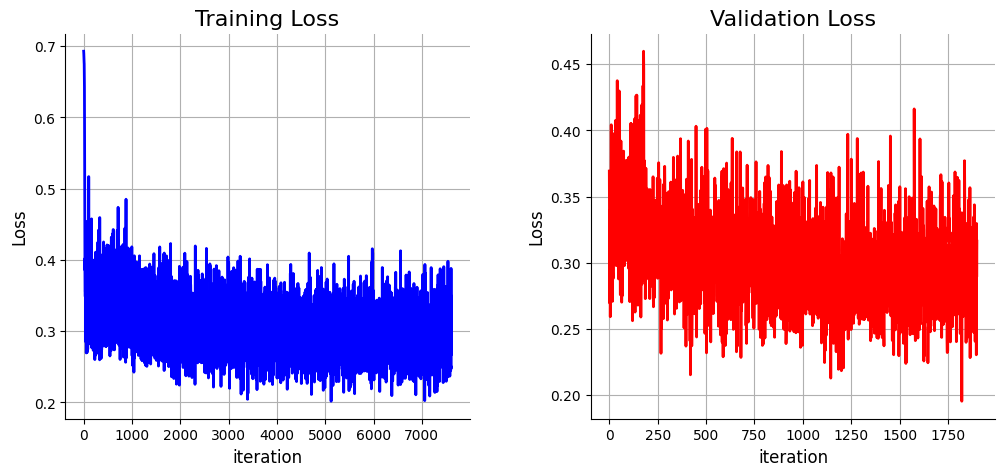

In [13]:
num_epoch = 10
model = SimpleLSTM().to(device)
train(train_loader, valid_loader, model, "SimpleLSTM", epochs_num = num_epoch)

## 產生輸出

In [14]:
model.eval()
output_list = []
with torch.no_grad():
  for datas in test_loader:
    datas = datas.to(device) 
    output_list.append(model(datas).cpu())

In [15]:
flatten_data = np.concatenate(output_list, axis=0)
showans = pd.DataFrame(flatten_data)

In [16]:
sample = pd.read_csv("./data/sample.csv")
answer = sample
for i in range(1,29):
    answer.iloc[:,i] = showans.iloc[:, i-1]
display(answer)
answer.to_csv("submit.csv", index=False)

<ipython-input-16-d77974f14215>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  answer.iloc[:,i] = showans.iloc[:, i-1]


,user_id,time_slot_0,time_slot_1,time_slot_2,time_slot_3,time_slot_4,time_slot_5,time_slot_6,time_slot_7,time_slot_8,...,time_slot_18,time_slot_19,time_slot_20,time_slot_21,time_slot_22,time_slot_23,time_slot_24,time_slot_25,time_slot_26,time_slot_27
0,30460,0.213727,0.167526,0.127305,0.562576,0.171279,0.141588,0.144927,0.547951,0.140843,...,0.129152,0.626752,0.165667,0.147965,0.114781,0.607468,0.137046,0.187828,0.078402,0.318745
1,30461,0.133336,0.352212,0.022318,0.010422,0.143810,0.396517,0.007526,0.004829,0.035776,...,0.006210,0.004728,0.032608,0.384854,0.005522,0.004411,0.053891,0.322343,0.015848,0.006984
2,30462,0.169530,0.222562,0.047063,0.063119,0.198339,0.256760,0.038379,0.076728,0.221214,...,0.038329,0.077830,0.169554,0.247002,0.031276,0.065508,0.190049,0.230168,0.039629,0.043822
3,30463,0.098298,0.087224,0.020537,0.024544,0.092703,0.095933,0.015035,0.020956,0.116054,...,0.011649,0.019882,0.105701,0.099948,0.009731,0.018317,0.133067,0.104699,0.020561,0.017762
4,30464,0.089119,0.148467,0.059471,0.014513,0.101003,0.182005,0.038216,0.009880,0.064251,...,0.027704,0.008763,0.053562,0.141369,0.025744,0.008439,0.064947,0.139080,0.040493,0.010071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,38071,0.074101,0.113318,0.053327,0.029417,0.081189,0.133585,0.040663,0.022878,0.054909,...,0.030301,0.019969,0.049112,0.113545,0.027952,0.020361,0.062463,0.116393,0.042493,0.019398
7612,38072,0.411322,0.419123,0.095850,0.055860,0.268877,0.300214,0.042062,0.027480,0.233687,...,0.029723,0.021146,0.138387,0.184725,0.016018,0.021244,0.167987,0.164939,0.025618,0.017560
7613,38073,0.391234,0.438817,0.100333,0.057989,0.246994,0.313470,0.042921,0.025825,0.184069,...,0.029785,0.020551,0.111738,0.200146,0.016884,0.021431,0.141141,0.177696,0.027493,0.018454
7614,38074,0.071916,0.115475,0.054219,0.025810,0.077800,0.135265,0.040023,0.018907,0.051073,...,0.029304,0.016545,0.046420,0.115140,0.027341,0.017214,0.059406,0.118363,0.042894,0.017051
